In [2]:
import pandas as pd
import warnings
import chardet

# Read the file in binary mode
with open("EnergyData.csv", 'rb') as file:
    rawdata = file.read()

# Use result to find encoding for csv reading
result = chardet.detect(rawdata)
#print(result)

In [3]:
# Create function for mapping states to regions
def state_to_region(state_name):
    state_region_mapping = {
        # Northeast
        'Connecticut': 'Northeast', 'Maine': 'Northeast', 'Massachusetts': 'Northeast',
        'New Hampshire': 'Northeast', 'Rhode Island': 'Northeast', 'Vermont': 'Northeast',
        'New Jersey': 'Northeast', 'New York': 'Northeast', 'Pennsylvania': 'Northeast',

        # Midwest
        'Illinois': 'Midwest', 'Indiana': 'Midwest', 'Michigan': 'Midwest',
        'Ohio': 'Midwest', 'Wisconsin': 'Midwest', 'Iowa': 'Midwest', 
        'Kansas': 'Midwest', 'Minnesota': 'Midwest', 'Missouri': 'Midwest', 
        'Nebraska': 'Midwest', 'North Dakota': 'Midwest', 'South Dakota': 'Midwest',

        # South
        'Delaware': 'South', 'Florida': 'South', 'Georgia': 'South', 
        'Maryland': 'South', 'North Carolina': 'South', 'South Carolina': 'South', 
        'Virginia': 'South', 'West Virginia': 'South', 'Washington, D.C.': 'South', 
        'Alabama': 'South', 'Kentucky': 'South', 'Mississippi': 'South', 
        'Tennessee': 'South', 'Arkansas': 'South', 'Louisiana': 'South', 
        'Oklahoma': 'South', 'Texas': 'South',

        # West
        'Arizona': 'West', 'Colorado': 'West', 'Idaho': 'West', 
        'Montana': 'West', 'Nevada': 'West', 'New Mexico': 'West', 
        'Utah': 'West', 'Wyoming': 'West', 'Alaska': 'West', 
        'California': 'West', 'Hawaii': 'West', 'Oregon': 'West', 
        'Washington': 'West'
    }
    return state_region_mapping.get(state_name, 'US Territory')

# Define years we will be investigating
years = [year for year in range(2010, 2022)]

Below creates two data frames:

- transport_co2_ff: `Co2 emissions` for each state in each year
- transport_energy_ff: `Energy consumption` for each state in each year

In [4]:
warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)

# Read energy data set 
energy = pd.read_csv("EnergyData.csv", encoding='UTF-16', delimiter = "\t")

# Get transportation sector only
transport_energy = energy[energy["Sector"] == "Transportation"]

# Group by State, Year, and Measure
grouped_transport_energy = transport_energy.groupby(["State", 'Year of Year', 'Measure']).sum("Pivot Field Values").reset_index()

# Separate into energy consumption and co2 emmision data frames
grouped_transport_energy_consm = grouped_transport_energy[grouped_transport_energy['Measure'] == "Energy consumption (trillion Btu)"]
grouped_transport_energy_co2 = grouped_transport_energy[grouped_transport_energy['Measure'] == "Carbon dioxide emissions (million metric tons)"]

# Change col name to year, use only wanted years
grouped_transport_energy_co2.rename(columns={"Year of Year": "Year"}, inplace=True)
transport_co2 = grouped_transport_energy_co2[grouped_transport_energy_co2["Year"].isin(years)].reset_index(drop=True)

# Change name to reflect Co2 df and drop Measure
transport_co2.rename(columns={"Pivot Field Values": "Co2 Emission"}, inplace=True)
transport_co2_f = transport_co2.drop(columns= "Measure")

# Do again for energy consumption
grouped_transport_energy_consm.rename(columns={"Year of Year": "Year"}, inplace=True)
transport_energy = grouped_transport_energy_consm[grouped_transport_energy_consm["Year"].isin(years)].reset_index(drop=True)
transport_energy.rename(columns={"Pivot Field Values": "Energy Consumption"}, inplace=True)
transport_energy_f = transport_energy.drop(columns= "Measure")

# Create column for region
transport_co2_f["Region"] = transport_co2_f["State"].apply(state_to_region)
transport_energy_f["Region"] = transport_energy_f["State"].apply(state_to_region)
transport_co2_ff = transport_co2_f[transport_co2_f["Region"] != "US Territory"]
transport_energy_ff = transport_energy_f[transport_energy_f["Region"] != "US Territory"]

Below are two plots representing the change in Co2 and Energy in the last 40 years

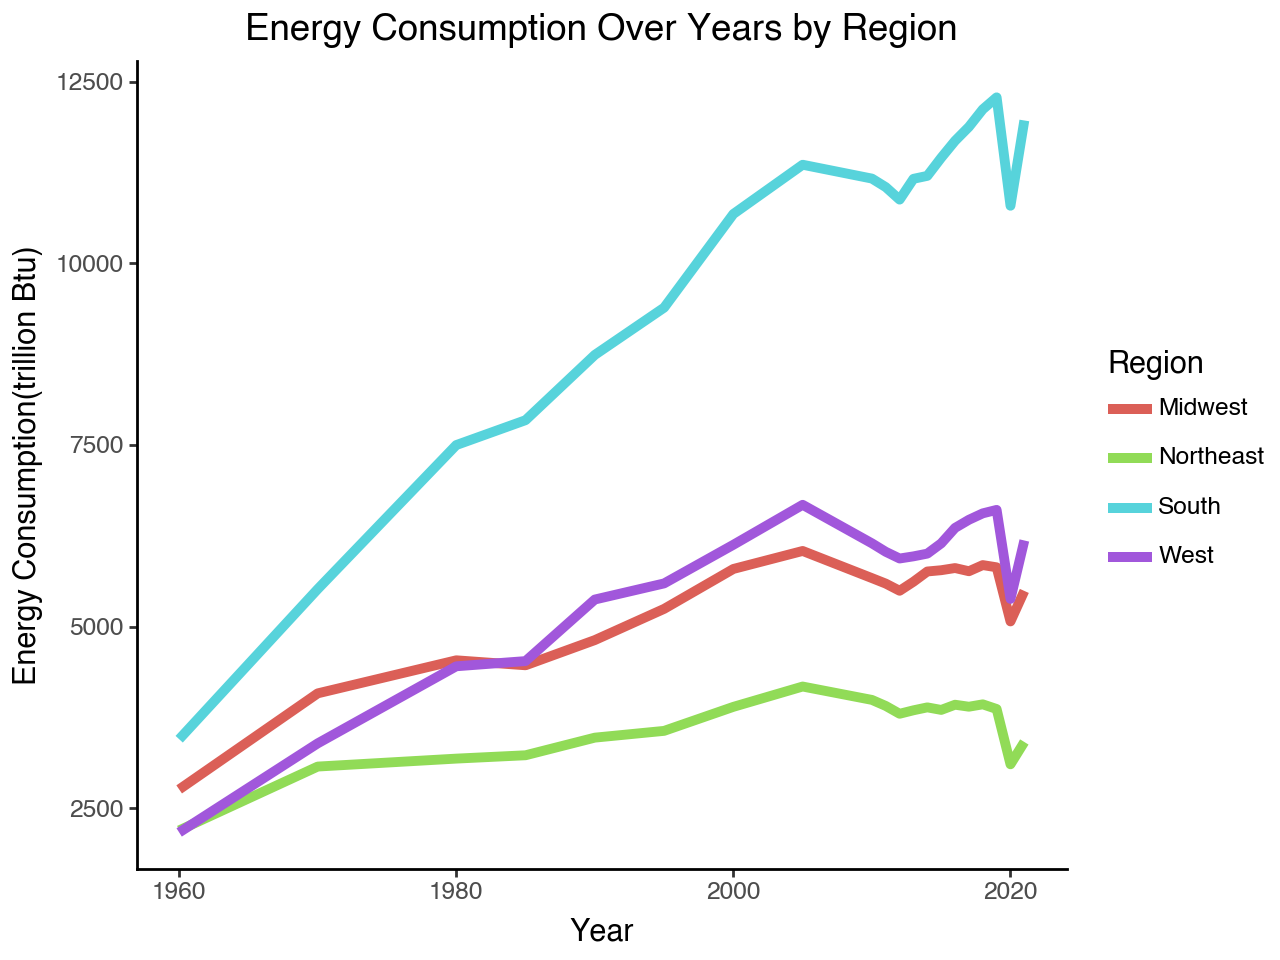

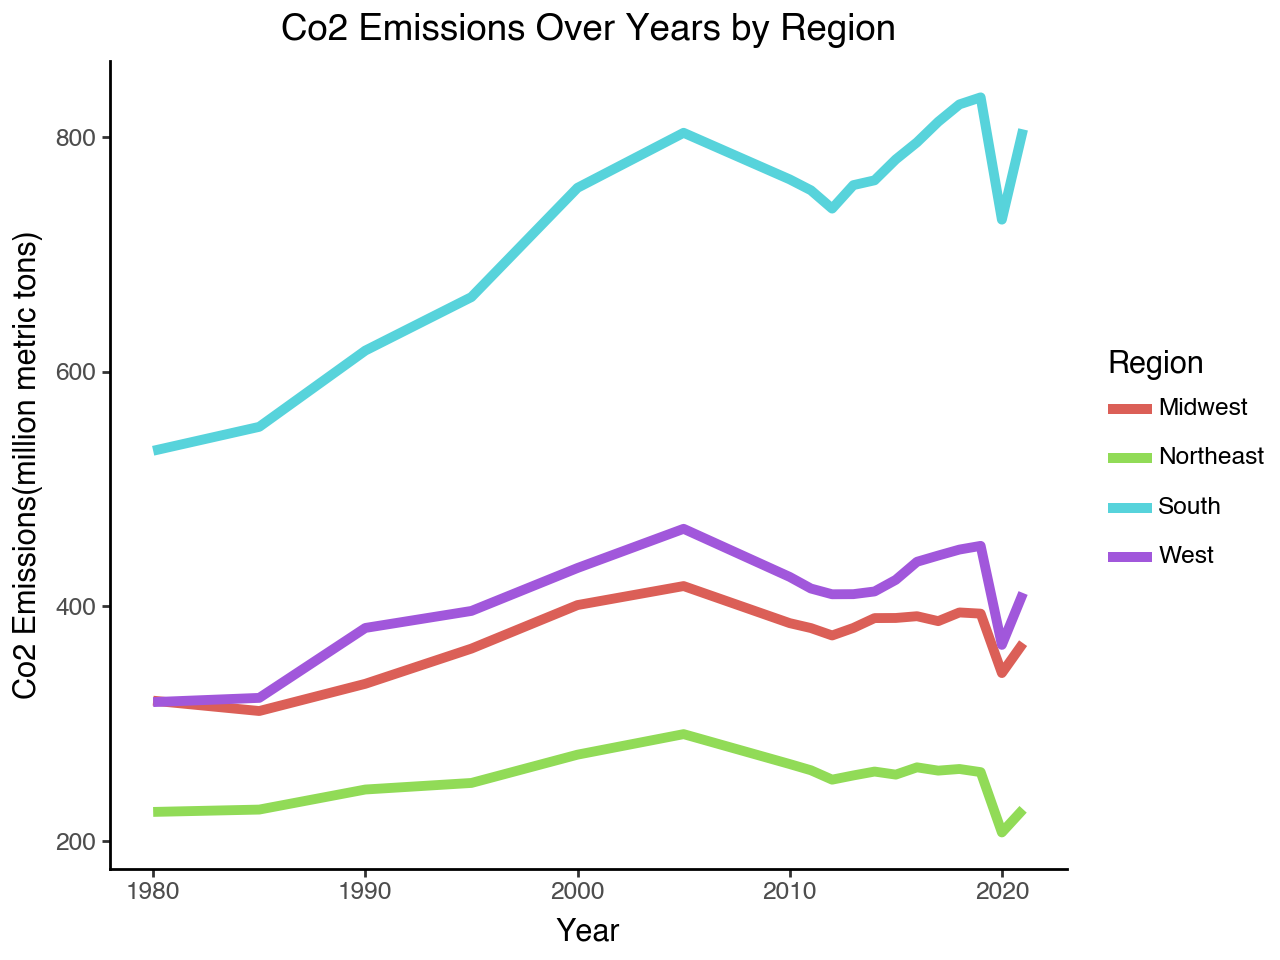

In [5]:
from plotnine import ggplot, geom_line, aes, labs, theme_classic

# Create Region for plotting
grouped_transport_energy_consm["Region"] = grouped_transport_energy_consm["State"].apply(state_to_region)
grouped2_transport_energy_consm = grouped_transport_energy_consm.groupby(["Region", "Year"]).sum("Pivot Field Values").reset_index()
grouped3_transport_energy_consm = grouped2_transport_energy_consm[grouped2_transport_energy_consm["Region"] != "US Territory"]

# Plot energy consumption through the years by region
energy_consumption_plot = (ggplot(grouped3_transport_energy_consm, aes(x= "Year", y= "Pivot Field Values", color= "Region"))
+ geom_line(size= 2)
+ labs(title="Energy Consumption Over Years by Region", x= "Year", y= "Energy Consumption(trillion Btu)")
+ theme_classic())

# Repeate last two steps for co2 emmisions
grouped_transport_energy_co2["Region"] = grouped_transport_energy_co2["State"].apply(state_to_region)
grouped2_transport_energy_co2 = grouped_transport_energy_co2.groupby(["Region", "Year"]).sum("Pivot Field Values").reset_index()
grouped3_transport_energy_co2 = grouped2_transport_energy_co2[grouped2_transport_energy_co2["Region"] != "US Territory"]

co2_consumption_plot = (ggplot(grouped3_transport_energy_co2, aes(x= "Year", y= "Pivot Field Values", color= "Region"))
+ geom_line(size= 2)
+ labs(title="Co2 Emissions Over Years by Region", x= "Year", y= "Co2 Emissions(million metric tons)")
+ theme_classic())

energy_consumption_plot.show()
co2_consumption_plot.show()

Below creates two data frames:

- revenue_aggregated: State and local government transportation `revenue` for each state in each year
- exp_aggregated: State and local government transportation `expenditure` for each state in each year

In [6]:
warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)

revenue = pd.read_csv("RevenueData.csv", encoding='UTF-16', delimiter = "\t")

# Take only Transportation data and State and Local Gov
transport_revenue = revenue[revenue["Mode"] == "Transit"]
transport_revenue_sl = revenue[revenue["Government"] == "State and Local"]
# Create two df, one for revenue and one for expenditure
transport_revenue_exp = transport_revenue_sl[transport_revenue_sl['Type'] == "Expenditure"]
transport_revenue_rev = transport_revenue_sl[transport_revenue_sl['Type'] == "Revenue"]
# Now can drop Gov, Mode and Type columns
transport_revenue_exp_drop = transport_revenue_exp.drop(columns= ["Government", "Mode", "Type"])
transport_revenue_rev_drop = transport_revenue_rev.drop(columns= ["Government", "Mode", "Type"])
# Create Region column
transport_revenue_exp_drop["Region"] = transport_revenue_exp_drop["State"].apply(state_to_region)
transport_revenue_rev_drop["Region"] = transport_revenue_rev_drop["State"].apply(state_to_region)
# Drop US Territory
transport_exp_ = transport_revenue_exp_drop[transport_revenue_exp_drop["Region"] != "US Territory"]
transport_rev_ = transport_revenue_rev_drop[transport_revenue_rev_drop["Region"] != "US Territory"]
# Keep only 2010 - 2021
transport_exp = transport_exp_[transport_exp_["Year"].isin(years)].reset_index(drop=True)
transport_rev = transport_rev_[transport_rev_["Year"].isin(years)].reset_index(drop=True)
# rename for joining later
transport_exp.rename(columns={"Amount (thousands)": "Expenditure"}, inplace=True)
transport_rev.rename(columns={"Amount (thousands)": "Revenue"}, inplace=True)
# Combine duplicate years
revenue_aggregated = transport_rev.groupby(['State', 'Year', 'Region'], as_index=False)['Revenue'].sum()
exp_aggregated = transport_exp.groupby(['State', 'Year', 'Region'], as_index=False)['Expenditure'].sum()


Below creates two data frames:

- commute_dr_drop2: Percentage of people who `drove` to work for each state in each year
- commute_pt_drop2: Percentage of people who took `public transportation` to work for each state in each year

In [7]:
warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)

commute = pd.read_csv("CommuteData.csv", encoding='UTF-16', delimiter = "\t")
# Take only Public Transportation and drive alone data
commute_reduced_pt = commute[commute["Mode"] == "Public transportation"]
commute_reduced_dr = commute[commute["Mode"] == "Drove alone"]
# Create region column
commute_reduced_pt["Region"] = commute_reduced_pt["State"].apply(state_to_region)
commute_reduced_dr["Region"] = commute_reduced_dr["State"].apply(state_to_region)
# Drop unwanted years and States
commute_pt = commute_reduced_pt[commute_reduced_pt["Year"].isin(years)].reset_index(drop=True)
commute_dr = commute_reduced_dr[commute_reduced_dr["Year"].isin(years)].reset_index(drop=True)
commute_pt_drop = commute_pt[commute_pt["Region"] != "US Territory"]
commute_dr_drop = commute_dr[commute_dr["Region"] != "US Territory"]
# Drop Mode
commute_dr_drop.rename(columns={"Commute mode share (percent)": "Drive Percent"}, inplace=True)
commute_dr_drop2 = commute_dr_drop.drop(columns= "Mode")
commute_pt_drop.rename(columns={"Commute mode share (percent)": "Public Transportation Percent"}, inplace=True)
commute_pt_drop2 = commute_pt_drop.drop(columns= "Mode")

Below creates one data frames:

- population_final: Estimated `population` for each state in each year

In [10]:
warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)

#2020-2023 Census Data
census2020 = pd.read_excel("/Users/williamkapner/Documents/GSB_544/GSB544Project/NST-EST2023-POP.xlsx",skiprows=3)
census2020 = census2020.rename(columns={
    'Unnamed: 0': 'State',
    'Unnamed: 1': 'Base Population',
    2020: 'POPESTIMATE2020',
    2021: 'POPESTIMATE2021',
    2022: 'POPESTIMATE2022',
    2023: 'POPESTIMATE2023',
})

census2020['State'] = census2020['State'].str.lstrip('.')

#Census Data 2010-2020
census2010 = pd.read_csv("/Users/williamkapner/Documents/GSB_544/GSB544Project/nst-est2019-popchg2010_2019.csv")


#Merging the Datasets
merged_census = pd.merge(census2010,census2020,left_on = "NAME" , right_on= "State",how = 'inner')
merged_census.head()
final_population = merged_census[['NAME', 'POPESTIMATE2010','POPESTIMATE2011','POPESTIMATE2012','POPESTIMATE2013','POPESTIMATE2014','POPESTIMATE2015','POPESTIMATE2016','POPESTIMATE2017','POPESTIMATE2018','POPESTIMATE2019','POPESTIMATE2020','POPESTIMATE2021','POPESTIMATE2022','POPESTIMATE2023']]

population = pd.melt(
    final_population, 
    id_vars=["NAME"],
    var_name="Year", 
    value_name="Estimate" 
)

# Extract the year from the 'Year' column
population["Year"] = population["Year"].str.extract(r'(\d{4})').astype(int)
# Sort the DataFrame by 'State' alphabetically and then by 'Year'
population = population.sort_values(by=["NAME", "Year"]).reset_index(drop=True)
# rename NAME to State
population.rename(columns={"NAME": "State"}, inplace=True)
# Create region column
population["Region"] = population["State"].apply(state_to_region)
# Drop unneeded states and years
population_year = population[population["Year"].isin(years)].reset_index(drop=True)
population_final = population_year[population_year["Region"] != "US Territory"]

population_final.rename(columns={"Estimate": "Population"}, inplace=True)

Below merges all of the previous date frames to create one final data frame:

- myData: Shows `Population`, `Region`, `Co2 Emmisions`, `Energy Consumption`, `Revenue`, `Expenditure`, `Public Transportation Percent`, and `Drive Percent` for each state in each year. 

In [11]:
dfs_to_merge = [
    population_final,
    transport_co2_ff, 
    transport_energy_ff, 
    revenue_aggregated, 
    exp_aggregated,  
    commute_pt_drop2,
    commute_dr_drop2
]

# Starting with the first DataFrame and merging iteratively
merged_data = dfs_to_merge[0]
for df in dfs_to_merge[1:]:
    merged_data = pd.merge(merged_data, df, on=["State", "Year", "Region"], how="left")


myData = merged_data.dropna()
myData.head()

,State,Year,Population,Region,Co2 Emission,Energy Consumption,Revenue,Expenditure,Public Transportation Percent,Drive Percent
0,Alabama,2010,4785437.0,South,32.2,478.219,43271414,45890521,0.004080,0.844724
1,Alabama,2011,4799069.0,South,32.3,478.194,42471487,46083685,0.004776,0.848534
2,Alabama,2012,4815588.0,South,31.8,472.026,45591379,48535991,0.004108,0.852861
3,Alabama,2013,4830081.0,South,31.6,466.384,47163698,50589087,0.004836,0.863611
4,Alabama,2014,4841799.0,South,31.6,465.321,45514101,50445291,0.004123,0.858900


In [34]:
grouped_data = myData.groupby(['Region', 'Year']).agg({
    'Co2 Emission': 'mean',
    'Expenditure': 'sum',
    'Population': 'sum',
    'Public Transportation Percent': 'mean'
}).reset_index()


grouped_data['emissions_pop'] = grouped_data['Co2 Emission']/grouped_data['Population']
grouped_data.head()

,Region,Year,Co2 Emission,Expenditure,Population,Public Transportation Percent,emissions_pop
0,Midwest,2010,32.150000,707273644,66974416.0,0.018813,4.800340e-07
1,Midwest,2011,31.800000,706429469,67157800.0,0.019369,4.735116e-07
2,Midwest,2012,31.275000,708537266,67336743.0,0.018391,4.644567e-07
3,Midwest,2013,31.808333,712105151,67560379.0,0.019863,4.708134e-07
4,Midwest,2014,32.508333,741267560,67745167.0,0.020187,4.798620e-07


In [24]:
from plotnine import ggplot, aes, geom_line, geom_point, labs, geom_smooth

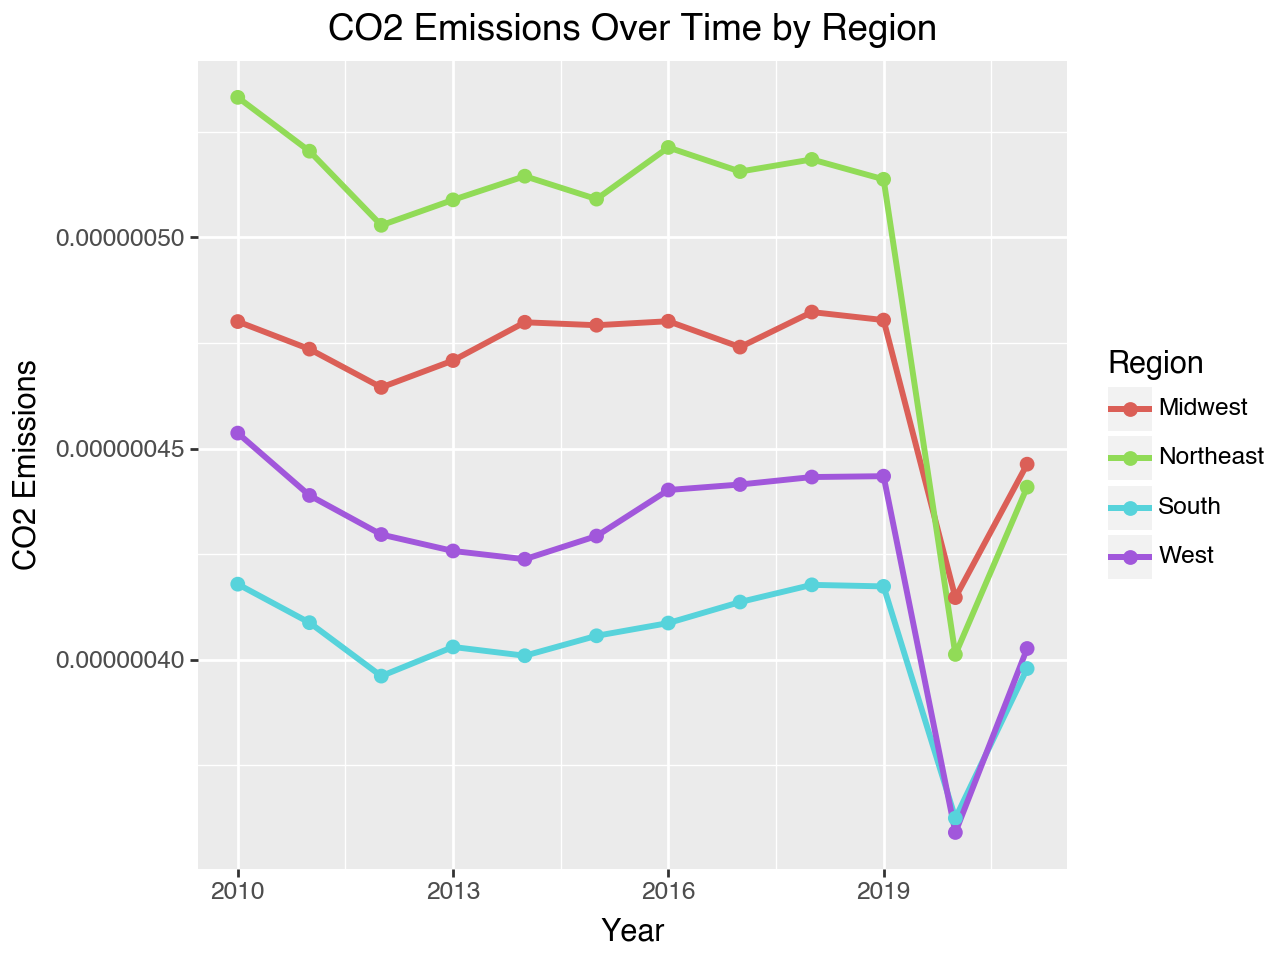

In [35]:
(ggplot(grouped_data, aes(x = "Year", y = 'emissions_pop', color = 'Region')) +
  geom_line(size = 1.2) +
  geom_point(size = 2) +
  labs(
    title = "CO2 Emissions Over Time by Region",
    x = "Year",
    y = "CO2 Emissions",
    color = "Region"
  ))

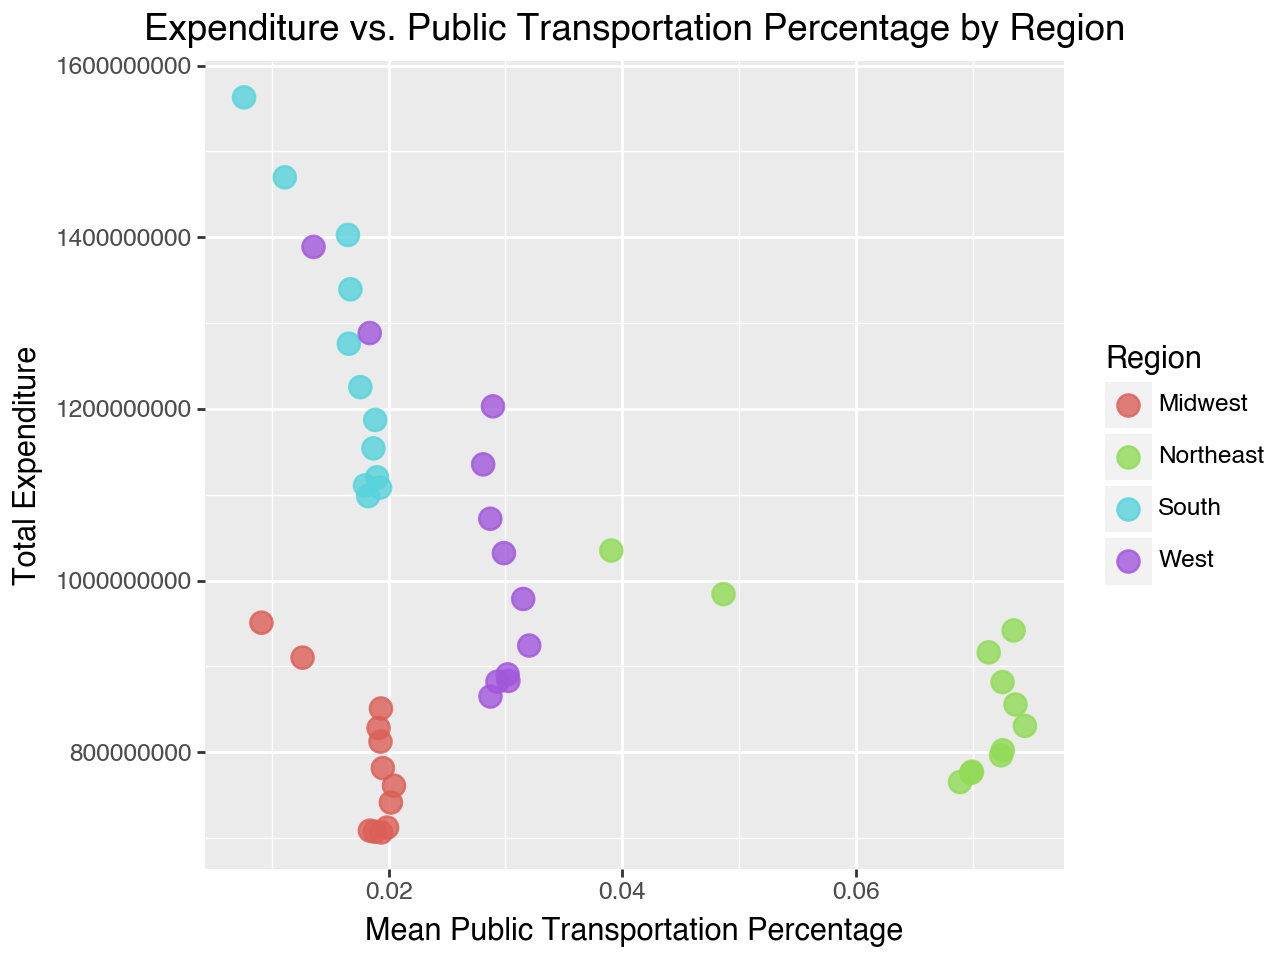

In [30]:
(
    ggplot(grouped_data, aes(x='Public Transportation Percent', y='Expenditure', color='Region')) +
    geom_point(size=4, alpha=0.8) +  # Larger points for better visibility
    labs(
        title="Expenditure vs. Public Transportation Percentage by Region",
        x="Mean Public Transportation Percentage",
        y="Total Expenditure",
        color="Region"
    )
)